In [1]:
import numpy as np
import pandas as pd
import spacy
import networkx as nx
import score as sc
import time
from sklearn.metrics import confusion_matrix, pairwise, f1_score, precision_score
from scipy.spatial import distance
from preprocessing.utils import plot_confusion_matrix
import matplotlib.pyplot as plt
import nltk
from collections import Counter, defaultdict
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import itertools
import torch
import importlib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

/Users/dannyyang/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import sys
importlib.reload(sys.modules['preprocessing.utils'])
from preprocessing.utils import plot_confusion_matrix

In [3]:
#https://github.com/huggingface/neuralcoref
#note: this NEEDS spacy 2.0.12 to work! downgrade with pip install spacy=2.0.12
import en_coref_md
nlp = spacy.load('en_core_web_sm')
coref = en_coref_md.load()

In [4]:
negating_words = set([
    "n't", "not", "no", 
    "never", "nobody", "non", "nope"])
doubting_words = set([
    'fake','fraud', 'hoax', 
    'false', 'deny', 'denies', 
    'despite', 'doubt', 
    'bogus', 'debunk', 'prank', 
    'retract', 'scam', "withdrawn",
    "misinformation"])
hedging_words = set([
    'allege', 'allegedly','apparently',
    'appear','claim','could',
    'evidently','largely','likely',
    'mainly','may', 'maybe', 'might',
    'mostly','perhaps','presumably',
    'probably','purport', 'purportedly',
    'reported', 'reportedly',
    'rumor', 'rumour', 'rumored', 'rumoured',
    'says','seem','somewhat',
    'unconfirmed'])
sus_words = doubting_words.union(hedging_words)

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

def get_sentiment(sentence):
    sent =  vader.polarity_scores(sentence)
    return [sent["pos"],sent["neg"],sent["neu"],sent["compound"]]

def get_avg_sentiment(lst):
    sents = np.array([get_sentiment(s) for s in lst])
    return list(np.mean(sents, axis = 0))

def get_diff_sentiment(a,b):
    return list(np.array(a) - np.array(b))

In [6]:
def train_test_split(bodies, stances, split=0.8):
    idx = np.random.permutation(np.arange(len(bodies)))
    bodies = bodies.values[idx]
    train = int(len(bodies)*0.8)
    bodies_tr = set([i[0] for i in bodies[:train]])
    bodies_val = set([i[0] for i in bodies[train:]])
    stances_tr = stances.loc[stances["Body ID"].isin(bodies_tr), :]
    stances_val = stances.loc[stances["Body ID"].isin(bodies_val), :]
    return stances_tr, stances_val

In [7]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head(15)

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss
11,Woman detained in Lebanon is not al-Baghdadi's...,1468,agree
14,"Soon Marijuana May Lead to Ticket, Not Arrest,...",47,discuss
16,Boko Haram Denies Nigeria Cease-Fire Claim,2463,discuss
17,"No, Robert Plant Didn’t Rip Up an $800 Million...",295,agree
19,ISIL Beheads American Photojournalist in Iraq,608,discuss


In [8]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [9]:
def get_body(n):
    return train_bodies.loc[lambda x: x["Body ID"] == n, "articleBody"].item()

In [10]:
def preprocess(text):
    text = text.replace("' ",' ')
    text = text.replace("'\n",'\n')
    text = text.replace(" '",' ')
    text = text.replace('"',' ')
    text = text.replace('“',' ')
    text = text.replace('”', ' ')
    text = text.replace(":", ". ")
    text = text.replace(";", ". ")
    text = text.replace("...", " ")
    return text

In [11]:
def cosine_similarity(x,y):
    if all([a == 0 for a in x]) or all([a == 0 for a in y]):
        return 0
    return 1 - np.nan_to_num(distance.cosine(x,y))

In [12]:
def get_topics(doc):
    """
    get topics of a sentence
    input: spacy doc
    output: dictionary with nouns as the key, and the set of noun chunks that contain the noun as the value
    special entry _vocab has the set of all tokens in the dict
    """
    subjs = {}
    for chunk in doc.noun_chunks:
        if len(chunk.root.text) > 2 and chunk.root.pos_ not in ["NUM", "SYM","PUNCT"]:
            txt = chunk.root.lemma_.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])
            subjs[txt].add(chunk.text.lower())
    subjects_= []
    for word in subjs:
        for phrase in subjs[word]:
            subjects_ += phrase.split(" ")
    subjs["_vocab"] = set(subjects_)
    return subjs

In [13]:
def get_svos(sent):
    """
    input: Spacy processed sentence
    output: dict of subj, dict of v, dict of obj (each word is lemmatized and lowercased)
    each entry in dict has key of lemmatized token, value is actual token (to do traversals with later if needed)
    """
    s = {}
    v = {}
    o = {}
    for token in sent:
        if token.dep_ == 'ROOT':
            v[token.lemma_.lower()] = token
        elif token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "agent","compound"]:
            s[token.lemma_.lower()] = token
        elif token.dep_ in ["dobj", "dative", "attr", "oprd", "pobj"]:
            o[token.lemma_.lower()] = token
    # https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md
    return (s,v,o)

In [14]:
def build_graph(doc):
    """
    build a NetworkX graph of the dependency tree
    input: spacy Doc
    output: networkx graph
    """
    edges = set()
    for token in doc:
        if token.pos_ not in ['SPACE']:
            for child in token.children:
                if child.pos_ not in ['SPACE']:
                    edges.add((token.lemma_.lower(),child.lemma_.lower()))
    graph = nx.DiGraph(list(edges))
    return graph

In [15]:
def get_edges(doc):
    """
    return list of edges
    """
    edges = []
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT', 'SYM']:
            for child in token.children:
                if child.pos_ not in ['SPACE', 'PUNCT', 'SYM']:
                    edges.append((
                        {"token":token.lemma_.lower(), "dep":token.dep_ , "pos":token.pos_},
                        {"token":child.lemma_.lower(), "dep":child.dep_ , "pos":child.pos_}
                    ))
    return edges

In [16]:
def get_summary(doc, subjects, n = 5):
    """
    get summary of n sentences in document
    first meaningful sentence will always be returned
    """
    subjects_ = subjects
    def score_sentence(sent):
        # not very robust right now
        score = 0
        word_count = 0
        for token in sent:
            word_count += 1
            t = token.lemma_.lower()
            if t in subjects_:
                score += 1
            elif t in negating_words or t in doubting_words or t in hedging_words:
                score += 1
        return score/word_count if word_count > 4 else 0
    sentences = [s for s in doc.sents]
    scored_sentences = [[idx, sent, score_sentence(sent)] for idx, sent in enumerate(sentences)]
    scored_sentences = [s for s in scored_sentences if s[2] > 0 and s[0] > 0] #filter out non-scoring sentences
    scored_sentences.sort(key = lambda x: x[2], reverse = True)
    top = scored_sentences[:n]
    top.sort(key = lambda x: x[0])
    scored_sentences.sort(key = lambda x: x[0])
    result = None
    if len(scored_sentences) == 0:
        result = [sentences[0]]
    else:
        result = [scored_sentences[0][1]] + [s[1] for s in top]
    return result

In [17]:
def get_shortest_path_to_negating(graph, subjects):
    """
    get the shortest path from each subject to any negating or doubting/hedging word
    returns: dictionary with subject as key, and 2-element list of path lengths [negating, doubting]
    - if a subject does not exist in graph or have a path to any negating word, then the value will be [None, None]
    """
    results = {}
    for s in subjects:
        results[s] = [None, None, None]
        if graph.has_node(s):
            for word in negating_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][0] == None or len(path) < results[s][0]:
                            results[s][0] = len(path)
                    except:
                        continue
            for word in hedging_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][1] == None or len(path) < results[s][1]:
                            results[s][1] = len(path)
                    except:
                        continue
            for word in doubting_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][2] == None or len(path) < results[s][2]:
                            results[s][2] = len(path)
                    except:
                        continue
    return results

In [18]:
def root_distance(graph, root):
    """
    as implemented in the Emergent paper - return the shortest distance between the given root and any 
    doubting or hedging words in the graph, or None if no such path exists
    """
    if root == None:
        return None
    min_dist = None
    for word in sus_words:
        if word in graph:
            try:
                path = nx.shortest_path(graph, source = root, target = word)
                if min_dist == None or len(path) < min_dist:
                    min_dist = len(path)
            except:
                continue
    return min_dist

In [19]:
def get_neg_ancestors(doc):
    """
    get the ancestors of every negating word
    input: spacy Doc
    returns: tuple  - set of words that were in the ancestor list of negating words, 
    set of words that were in ancestor list of refuting words, # negating words, # refuting words
    """
    results = [set(), set(), set(), 0, 0, 0]
    for token in doc:
        if token.lemma_.lower() in negating_words:
            results[0] = results[0].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2]).union(
                    set([child.lemma_.lower() for child in token.head.children if child.text != token.text and len(child) > 2])
                )
            )
            results[3] += 1
        elif token.lemma_.lower() in doubting_words:
            results[1] = results[1].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2]).union(
                    set([child.lemma_.lower() for child in token.head.children if child.text != token.text and len(child) > 2])
                )
            )
            results[4] += 1
        elif token.lemma_.lower() in hedging_words:
            results[2] = results[1].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2]).union(
                    set([child.lemma_.lower() for child in token.head.children if child.text != token.text and len(child) > 2])
                )
            )
            results[5] += 1
    return tuple(results)

In [20]:
from sentic import SenticPhrase
text = "Hello, World!"
sp = SenticPhrase(text)

def get_sentics(sent):
    """
        input: Spacy processed sentence
        output: a tuple containing the polarity score and a list of sentic values 
            (pleasantness, attention, sensitiviy, aptitude )
    """
    info = sp.info(sent)
          
    # Sometimes sentic doesn't returns any sentics values, seems to be only when purely neutral. 
    # Some sort of tag to make sure this is true could help with classiciation! (if all 0's not enough)
    sentics = {"pleasantness":0, "attention":0, "sensitivity":0, "aptitude":0}
    sentics.update(info["sentics"])
    return [info['polarity'], sentics['aptitude'], sentics['attention'], sentics['sensitivity'], sentics['pleasantness']]

In [21]:
sp.info("Hello my name is Danny")['polarity'], sp.info("Hello my name is Danny")['sentics']

(-0.77,
 {'aptitude': -0.74,
  'attention': 0.0,
  'pleasantness': -0.94,
  'sensitivity': 0.636})

Boko Haram ceasefire doubts after attacks reported in Nigeria
[doubts]
{'ceasefire': {'ceasefire', 'boko haram ceasefire'}, 'attack': {'attack', 'attacks'}, 'nigeria': {'nigeria'}, '_vocab': {'haram', 'ceasefire', 'boko', 'attacks', 'attack', 'nigeria'}}
({'boko': Boko, 'haram': Haram, 'ceasefire': ceasefire}, {'doubt': doubts}, {'attack': attacks, 'nigeria': Nigeria})
(set(), {'ceasefire', 'after'}, set(), 0, 1, 0)


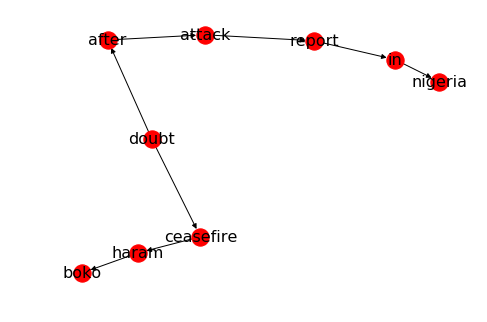

In [22]:
h_id = 12
df = train_stances[train_stances["Stance"] == "disagree"]
test = nlp(preprocess(list(df.values)[h_id][0]))
print(test)
print([t for t in test if t.dep_ == "ROOT"])
# print(test)
# test_graph = build_graph(test)
edges = get_edges(test)
set_edges = set([(e[0]['token'], e[1]['token']) for e in edges])
test_graph = nx.DiGraph(list(set_edges))
test_subj = get_topics(test)
print(test_subj)
test_svo = get_svos(test)
print(test_svo)
print(get_neg_ancestors(test))
# pos = nx.spring_layout(test_graph, iterations = 200)
nx.draw(test_graph, font_size=16, with_labels = True)
plt.show()

In [23]:
body_text = get_body(list(df.values)[h_id][1])
body = coref(preprocess(body_text))
resolved = body._.coref_resolved
body = nlp(preprocess(resolved))
print(set(test_subj["_vocab"]).union(set(test_svo[0])).union(set(test_svo[1])).union(set(test_svo[2])))
body_graph = build_graph(body)
summary = get_summary(body, set(test_subj["_vocab"]).union(set(test_svo[0])).union(set(test_svo[1])).union(set(test_svo[2])), 5)
print("++++++++")
for s in summary:
    print(s)
    svo_s = get_svos(s)
    print(get_shortest_path_to_negating(body_graph, test_subj))
    print(svo_s)
    print(root_distance(body_graph, list(svo_s[1].keys())[0]))
    print(get_neg_ancestors(s))
    print("")

{'haram', 'ceasefire', 'doubt', 'boko', 'attacks', 'attack', 'nigeria'}
++++++++
a truce with militant Islamist group Boko Haram, who look set to the release schoolgirls it abducted earlier this year


{'ceasefire': [None, None, None], 'attack': [None, None, None], 'nigeria': [None, None, None], '_vocab': [None, None, None]}
({'group': group, 'boko': Boko, 'who': who, 'release': release, '-pron-': it}, {'truce': truce}, {'haram': Haram, 'schoolgirl': schoolgirls})
5
(set(), set(), set(), 0, 0, 0)

Boko Haram had demanded the release of detained extremists in exchange for the girls, but Nigeria president Goodluck Jonathan would not swap prisoners.


{'ceasefire': [None, None, None], 'attack': [None, None, None], 'nigeria': [None, None, None], '_vocab': [None, None, None]}
({'boko': Boko, 'haram': Haram, 'nigeria': Nigeria, 'president': president, 'goodluck': Goodluck, 'jonathan': Jonathan}, {'demand': demanded}, {'release': release, 'extremist': extremists, 'exchange': exchange, 'girl':

# Preprocess headline and body

In [24]:
headline_info = {}
body_info = {}
start = time.time()
stance_data = list(train_stances.values)
body_data = list(train_bodies.values)
for headline in range(len(stance_data)):
    if headline % 2500 == 0:
        print("Processed "+str(headline))
    h, b_id, s = tuple(stance_data[headline])
    if h not in headline_info:
        nlp_h = nlp(preprocess(h))
        headline_edges = get_edges(nlp_h)
        headline_graph = nx.DiGraph(list(set([(e[0]['token'], e[1]['token']) for e in headline_edges])))
        headline_subj = get_topics(nlp_h)
        headline_svo = get_svos(nlp_h)
        headline_root_dist = root_distance(headline_graph, list(headline_svo[1].keys())[0])
        headline_neg_ancestors = get_neg_ancestors(nlp_h)
        headline_info[h] = (nlp_h, headline_graph, headline_subj, headline_svo, headline_root_dist, headline_neg_ancestors, headline_edges)
print("Done!")
for body in range(len(body_data)):
    if body % 100 == 0:
        print("Processed "+str(body))
    b_id, txt = tuple(body_data[body])
    nlp_a = coref(preprocess(txt))
    nlp_b = nlp(nlp_a._.coref_resolved.lower())
    body_graph = build_graph(nlp_b)
    body_info[b_id] = (nlp_b, body_graph)
print("Done!")
end = time.time()
print(int(end-start))

Processed 0
Processed 2500
Processed 5000
Processed 7500
Processed 10000
Processed 12500
Done!
Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Processed 1000
Processed 1100
Processed 1200
Processed 1300
Processed 1400
Processed 1500
Processed 1600
Done!
764


In [25]:
list(body_info.values())[0]

(a small meteorite crashed into a wooded area in nicaragua's capital of managua overnight, nicaragua said sunday. residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the associated press reports. 
 
 government spokeswoman rosario murillo said a committee formed by nicaragua to study the event determined a committee formed by the government to study the event was a  relatively small  meteorite that  appears to have come off an asteroid that was passing close to earth.  house-sized asteroid 2014 rc, which measured 60 feet in diameter, skimmed earth this weekend, abc news reports. 
 government spokeswoman rosario murillo said nicaragua will ask international experts to help local scientists in understanding what happened.
 
 the crater left by a  relatively small  meteorite that  appears to have come off an asteroid that was passing close to earth had a radius of 39 feet and a depth of 16 feet,  said humberto saballos, a volcanologist wit

In [26]:
with open('saved_data/relevance_headline_info.json', 'w') as fp:
    json.dump(headline_info, fp)
    
json_body_info = {}
for k in body_info:
    body_info[k]['vocabulary'] = list(body_info[k]['vocabulary'])
    json_body_info[str(k)] = body_info[k]
with open('saved_data/relevance_body_info.json', 'w') as fp:
    json.dump(json_body_info, fp)

NameError: name 'json' is not defined

In [ ]:
import json
body_graphs = {}
for i in body_info:
    body_graphs[i] = list(body_info[i][1].edges())
with open('saved_data/body_graphs.json', 'w') as fp:
    json.dump(body_graphs, fp)
    
headline_graphs = {}
for i in headline_info:
    headline_graphs[i] = list(headline_info[i][-1])
with open('saved_data/headline_edges.json', 'w') as fp:
    json.dump(headline_graphs, fp)

In [27]:
def get_sentence_vec(s):
    vecs = [token.vector for token in s]
    return np.nan_to_num(np.product(vecs, axis = 0))

def get_features(stance_df, n_sent = 5):
    start = time.time()
    data = list(stance_df.values)
    features = []
    actual = []
    for item in data:
        h, b, s = tuple(item)
        headline, headline_graph, headline_subjs, headline_svo, headline_root_dist, headline_neg_ancestors, headline_edges  = headline_info[h]
        body, body_graph = body_info[b]
        
        h_important_words = set(headline_subjs["_vocab"]).union(set(headline_svo[0])).union(set(headline_svo[1])).union(set(headline_svo[2]))
        
        #sometimes the coref deletes bodies that are one sentence
        if len(body) == 0:
            body = nlp(preprocess(get_body(b)))
            body_graph = build_graph(body)

        #return the shortest path to negating word for each subject in headline_subjs, if one exists
        neg_h = get_shortest_path_to_negating(headline_graph, h_important_words)
        neg_b = get_shortest_path_to_negating(body_graph, h_important_words)

        #body summary
        summary = get_summary(body, h_important_words, n_sent)
        first_summ_sentence = summary[0]
        
        summary_svos = [get_svos(s) for s in summary]
        summary_root_dist = [root_distance(body_graph, list(s[1].keys())[0]) for s in summary_svos]
        summary_neg_ancestors = [get_neg_ancestors(s) for s in summary]
        summary_neg_counts = [s[3:] for s in summary_neg_ancestors]
        
        summary_neg_ancestors_superset = [set(), set(), set()]
        for a in summary_neg_ancestors:
            summary_neg_ancestors_superset[0] = summary_neg_ancestors_superset[0].union(a[0])
            summary_neg_ancestors_superset[1] = summary_neg_ancestors_superset[1].union(a[1])
            summary_neg_ancestors_superset[2] = summary_neg_ancestors_superset[2].union(a[2])
            
        #ancestors
        h_anc = [[1 if w in headline_neg_ancestors[0] else -1 for w in h_important_words],
                [1 if w in headline_neg_ancestors[1] else -1 for w in h_important_words],
                [1 if w in headline_neg_ancestors[2] else -1 for w in h_important_words]]
        b_anc = [[1 if w in summary_neg_ancestors_superset[0] else -1 for w in h_important_words],
                [1 if w in summary_neg_ancestors_superset[1] else -1 for w in h_important_words],
                [1 if w in summary_neg_ancestors_superset[2] else -1 for w in h_important_words]]    
        neg_anc_sim = cosine_similarity(h_anc[0], b_anc[0])
        doubt_anc_sim = cosine_similarity(h_anc[1], b_anc[1])
        hedge_anc_sim = cosine_similarity(h_anc[2], b_anc[2])
        neg_anc_overlap = len(headline_neg_ancestors[0].union(summary_neg_ancestors_superset[0]))
        doubt_anc_overlap = len(headline_neg_ancestors[1].union(summary_neg_ancestors_superset[1]))
        hedge_anc_overlap = len(headline_neg_ancestors[2].union(summary_neg_ancestors_superset[2]))
        #svo
        body_s, body_v, body_o = {}, {}, {}
        headline_s, headline_v, headline_o = headline_svo
        for svo in summary_svos:
            body_s.update(svo[0])
            body_v.update(svo[1])
            body_o.update(svo[2])
        body_s_vec = list(np.sum([body_s[s].vector for s in body_s], axis = 0)) if len(body_s) > 0 else np.zeros(384)
        body_v_vec = list(np.sum([body_v[s].vector for s in body_v], axis = 0)) if len(body_v) > 0 else np.zeros(384)
        body_o_vec = list(np.sum([body_o[s].vector for s in body_o], axis = 0)) if len(body_o) > 0 else np.zeros(384)
    
        headline_s_vec = list(np.sum([headline_s[s].vector for s in headline_s], axis = 0)) if len(headline_s) > 0 else np.zeros(384)
        headline_v_vec = list(np.sum([headline_v[s].vector for s in headline_v], axis = 0)) if len(headline_v) > 0 else np.zeros(384)
        headline_o_vec = list(np.sum([headline_o[s].vector for s in headline_o], axis = 0)) if len(headline_o) > 0 else np.zeros(384)
        
        cos_sim_s = cosine_similarity(body_s_vec, headline_s_vec)
        cos_sim_v = cosine_similarity(body_v_vec, headline_v_vec)
        cos_sim_o = cosine_similarity(body_o_vec, headline_o_vec)
        
        #negating paths
        headline_paths = [neg_h[x] for x in neg_h]
        headline_neg_paths = [1 if x[0] != None else -1 for x in headline_paths]
        headline_doubt_paths = [1 if x[1] != None else -1 for x in headline_paths]
        headline_hedge_paths = [1 if x[2] != None else -1 for x in headline_paths]
        body_paths = [neg_b[x] for x in neg_h]
        body_neg_paths = [1 if x[0] != None else -1 for x in body_paths]
        body_doubt_paths = [1 if x[1] != None else -1 for x in body_paths]
        body_hedge_paths = [1 if x[2] != None else -1 for x in body_paths]
        
        neg_path_cos_sim = cosine_similarity(headline_neg_paths, body_neg_paths)
        hedge_path_cos_sim = cosine_similarity(headline_hedge_paths, body_hedge_paths)
        doubt_path_cos_sim = cosine_similarity(headline_doubt_paths, body_doubt_paths)
        
        #root distance
        summary_root_dists = [x if x != None else 15 for x in summary_root_dist]
        avg_summary_root_dist = sum(summary_root_dists)/len(summary_root_dists)
        root_dist_feats = [headline_root_dist, avg_summary_root_dist]
        root_dist_feats = [x/15 if x != None else 1 for x in root_dist_feats]
        root_dist_feats = root_dist_feats + [int(headline_root_dist == None), len([x for x in summary_root_dist if x != None])]
    
        #sentiment
        headline_sent = get_sentiment(headline.text)
        body_sents = [get_sentiment(s.text) for s in summary]
        avg_body_sent = list(np.mean(body_sents, axis = 0))
        diff_avg_sents = list(np.array(headline_sent) - avg_body_sent)
        diff_sents = list(np.sum([get_diff_sentiment(headline_sent, s) for s in body_sents], axis = 0))
        sent_cos_sim = cosine_similarity(headline_sent, avg_body_sent)

        headline_sentics = get_sentics(headline.text)
        body_sentics = [get_sentics(s.text) for s in summary]
        avg_body_sentics = list(np.mean(body_sentics, axis = 0))
        diff_avg_sentics = list(np.array(headline_sentics) - avg_body_sentics)
        diff_sentics = list(np.sum([get_diff_sentiment(headline_sentics, s) for s in body_sentics], axis = 0))
        sentics_cos_sim = cosine_similarity(headline_sentics, avg_body_sentics)
        
        #bow
        headline_vocab = set([tok.lemma_.lower() for tok in headline])
        fst_summ_vocab = set([tok.lemma_.lower() for tok in first_summ_sentence])
        total_vocab = list(headline_vocab.union(fst_summ_vocab))
        headline_embedding = [1 if tok in headline_vocab else -1 for tok in total_vocab]
        fst_summ_embedding = [1 if tok in fst_summ_vocab else -1 for tok in total_vocab]
        bow_cos_sim = cosine_similarity(headline_embedding, fst_summ_embedding)
        
        #word vecs
        cos_sims = [cosine_similarity(get_sentence_vec(s), headline.vector) for s in summary]
        fst_cos_sim = cos_sims[0]
        avg_cos_sim = sum(cos_sims)/len(cos_sims)
        
        #neg_hedge_doubt distributions
        hd_dist = list(headline_neg_ancestors[3:])
        body_dist = list(np.sum(summary_neg_counts, axis = 0))
        dist_sim = cosine_similarity(hd_dist, body_dist)
        #build final features list
        fts = (
            [fst_cos_sim, avg_cos_sim, bow_cos_sim, 
                neg_path_cos_sim, hedge_path_cos_sim, doubt_path_cos_sim,
                neg_anc_sim, hedge_anc_sim, doubt_anc_sim,
                neg_anc_overlap, hedge_anc_overlap, doubt_anc_overlap,
                cos_sim_s, cos_sim_v, cos_sim_o,
                dist_sim, sent_cos_sim, sentics_cos_sim] + 
            diff_avg_sents + diff_sents + diff_avg_sentics + diff_sentics + 
            root_dist_feats + hd_dist + body_dist +
            headline_sent + avg_body_sent + headline_sentics + avg_body_sentics
        )
        features.append(fts)
        actual.append(s)
    end = time.time()
    print(int(end-start))
    return features, actual

# Generate Features from headline/body pairs

In [28]:
stance_data = get_features(train_stances, 5)
stance_dict = {}
for idx, d in enumerate(list(train_stances.values)):
    h, b, s = d
    stance_dict[(h, b)] = stance_data[0][idx]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


307


In [29]:
list(stance_dict.values())[0:3]

[[0.11802282236784989,
  -0.05183889497504209,
  -0.7872340425531914,
  0.33333333333333326,
  1.0,
  0.33333333333333326,
  1.0,
  1.0,
  1.0,
  2,
  0,
  0,
  0.6168395687891529,
  -0.020541000941550314,
  0.6307555678279209,
  0,
  0.9939434307009911,
  0.9249589911238665,
  -0.03183333333333333,
  0.0,
  0.03183333333333327,
  -0.1022,
  -0.191,
  0.0,
  0.19099999999999995,
  -0.6132,
  0.02938333333333333,
  0.0993333333333333,
  0.12477499999999997,
  -0.04901666666666666,
  -0.025458333333333357,
  0.17630000000000004,
  0.5959999999999999,
  0.7486499999999999,
  -0.2940999999999999,
  -0.15275000000000008,
  1,
  0.7666666666666667,
  1,
  6,
  0,
  0,
  0,
  1,
  0,
  0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.03183333333333333,
  0.0,
  0.9681666666666667,
  0.1022,
  0.094,
  0.261,
  0.142,
  -0.06,
  -0.05,
  0.06461666666666667,
  0.1616666666666667,
  0.017225000000000018,
  -0.01098333333333334,
  -0.024541666666666646],
 [-0.13780430172058988,
  -0.042053238340480616,
  -0.7

In [33]:
def train_multiple(models, samplings = []):
    """
    helper function for training on models
    this isn't true K-fold CV because of the way we do our splits and augmentation
    models: a list of instantiated models
    sampling: list of 3 ints, representing how much we should oversample agree, disagree, discuss
            for example, [1,1,2] will sample each discuss item twice
    """
    stances_tr, stances_val = train_test_split(train_bodies, train_stances)
    disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
    agrees = stances_tr[stances_tr["Stance"]=="agree"]
    discusses = stances_tr[stances_tr["Stance"]=="discuss"]
    for m in range(len(models)):
        sampling = samplings[m]
        model = models[m]
        print("Model "+str(m + 1))
        disagrees_ = disagrees.sample(frac=sampling[1], replace = True).reset_index(drop=True)
        agrees_ = agrees.sample(frac=sampling[0], replace = True).reset_index(drop=True)
        discusses_ = discusses.sample(frac=sampling[2], replace = True).reset_index(drop=True)
        stances_tr_augmented = pd.concat((agrees_, disagrees_, discusses_)).sample(frac=1).reset_index(drop=True)
        training_data = [[],[]]
        for h,b,s in list(stances_tr_augmented.values):
            training_data[0].append(stance_dict[(h,b)])
            training_data[1].append(s)
        testing_data = [[],[]]
        for h,b,s in list(stances_val.values):
            testing_data[0].append(stance_dict[(h,b)])
            testing_data[1].append(s)
        c1, c2 = Counter(training_data[1]), Counter(testing_data[1])
        baseline_tr = max([c1['agree'],c1['disagree'],c1['discuss']])/(c1['agree']+c1['disagree']+c1['discuss'])
        baseline_val = max([c2['agree'],c2['disagree'],c2['discuss']])/(c2['agree']+c2['disagree']+c2['discuss'])
        print("Training Baseline {0:.2f}% Testing Baseline {1:.2f}%".format(baseline_tr * 100, baseline_val * 100))
        model.fit(training_data[0], training_data[1])
        tr_acc = model.score(training_data[0], training_data[1])
        print('{0:.2f}% training accuracy, vs Baseline {1:.2f}%'.format(tr_acc*100, (tr_acc-baseline_tr)*100))
        val_acc = model.score(testing_data[0], testing_data[1])
        print('{0:.2f}% validation accuracy, vs Baseline {1:.2f}%'.format(val_acc*100, (val_acc-baseline_val)*100))
    training_data = [[],[]]
    for h,b,s in list(stances_tr.values):
        training_data[0].append(stance_dict[(h,b)])
        training_data[1].append(s)
    testing_data = [[],[]]
    for h,b,s in list(stances_val.values):
        testing_data[0].append(stance_dict[(h,b)])
        testing_data[1].append(s)
    fold_data = training_data, testing_data
    print("done!")
    return models, fold_data

In [31]:
def label_to_int(labels):
    return [(1 if l == "agree" else (0 if l == "discuss" else -1)) for l in labels]

# Simple Model

Counter({'discuss': 7205, 'agree': 4119, 'disagree': 4068}) Counter({'discuss': 1704, 'agree': 736, 'disagree': 162})
Training Baseline 46.81% Testing Baseline 65.49%
88.25% training accuracy
68.45% validation accuracy
Baseline comparison: TR 41.44% VAL 2.96%
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    288    |    38     |    410    |     0     |
-------------------------------------------------------------
| disagree  |    18     |    46     |    98     |     0     |
-------------------------------------------------------------
|  discuss  |    140    |    117    |   1447    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 1986.25 out of 2602.0	(76.33551114527286%)
F1 Score

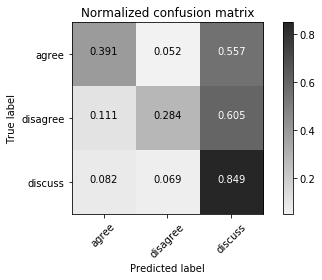

In [32]:
sampling = [1.4,6,1]
stances_tr, stances_val = train_test_split(train_bodies, train_stances)
disagrees = stances_tr[stances_tr["Stance"]=="disagree"].sample(frac=sampling[1], replace = True).reset_index(drop=True)
agrees = stances_tr[stances_tr["Stance"]=="agree"].sample(frac=sampling[0], replace = True).reset_index(drop=True)
discusses = stances_tr[stances_tr["Stance"]=="discuss"].sample(frac=sampling[2], replace = True).reset_index(drop=True)
stances_tr_augmented = pd.concat((agrees, disagrees, discusses)).sample(frac=1).reset_index(drop=True)
training_data = [[],[]]
for h,b,s in list(stances_tr_augmented.values):
    training_data[0].append(stance_dict[(h,b)])
    training_data[1].append(s)
testing_data = [[],[]]
for h,b,s in list(stances_val.values):
    testing_data[0].append(stance_dict[(h,b)])
    testing_data[1].append(s)
c1, c2 = Counter(training_data[1]), Counter(testing_data[1])
baseline_tr = max([c1['agree'],c1['disagree'],c1['discuss']])/(c1['agree']+c1['disagree']+c1['discuss'])
baseline_val = max([c2['agree'],c2['disagree'],c2['discuss']])/(c2['agree']+c2['disagree']+c2['discuss'])
print(c1, c2)
print("Training Baseline {0:.2f}% Testing Baseline {1:.2f}%".format(baseline_tr * 100, baseline_val * 100))

model = RandomForestClassifier(max_depth = 10, n_estimators=500, random_state = 0)
#model = LogisticRegression(max_iter = 200)
# model = SVC()
# model = GradientBoostingClassifier(n_estimators = 500, subsample = 0.1, learning_rate = 0.01, random_state=0)
# models = list(trained_models)

model.fit(training_data[0], training_data[1])
tr_acc = model.score(training_data[0], training_data[1])
print('{0:.2f}% training accuracy'.format(tr_acc*100))

val_acc = model.score(testing_data[0], testing_data[1])
print('{0:.2f}% validation accuracy'.format(val_acc*100))
print("Baseline comparison: TR {0:.2f}% VAL {1:.2f}%".format((tr_acc-baseline_tr)*100,(val_acc-baseline_val)*100))

actual = testing_data[1]
predicted = model.predict(testing_data[0])
# actual = actual + ["unrelated"] * 7500
# predicted = np.concatenate((predicted, ["unrelated"] * 7500),axis = 0)
sc.report_score(actual, predicted)
print("F1 Score")
print(f1_score(actual, predicted, average = None))
print("Avg Precision Score")
print(precision_score(actual, predicted, average = None))
matrix = confusion_matrix(actual,predicted)
plot_confusion_matrix(matrix, classes=["agree","disagree", "discuss"],
                      title='Normalized confusion matrix')
plt.show()

# Stacked Model

Model 1
Training Baseline 33.77% Testing Baseline 66.25%
100.00% training accuracy, vs Baseline 66.23%
68.85% validation accuracy, vs Baseline 2.60%
Model 2
Training Baseline 66.38% Testing Baseline 66.25%
100.00% training accuracy, vs Baseline 33.62%
69.93% validation accuracy, vs Baseline 3.68%
Model 3
Training Baseline 47.64% Testing Baseline 66.25%
100.00% training accuracy, vs Baseline 52.36%
70.82% validation accuracy, vs Baseline 4.57%
Model 4
Training Baseline 33.77% Testing Baseline 66.25%
55.73% training accuracy, vs Baseline 21.96%
52.71% validation accuracy, vs Baseline -13.53%
Model 5
Training Baseline 47.64% Testing Baseline 66.25%
57.48% training accuracy, vs Baseline 9.84%
60.82% validation accuracy, vs Baseline -5.43%
done!
97.69% training accuracy
70.41% validation accuracy
Baseline comparison: TR 49.49% VAL 4.35%
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
--------------------------------

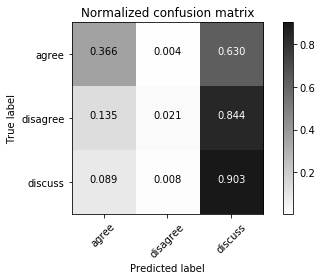

In [89]:
models = [
RandomForestClassifier(n_estimators = 400),
RandomForestClassifier(n_estimators = 400),
RandomForestClassifier(n_estimators = 400), 
LogisticRegression(),
LogisticRegression(), #, subsample = 0.2, learning_rate = 0.025, random_state=0, min_samples_leaf = 3),
]
trained_models, trained_data = train_multiple(models, [
    [2.4,10,1], 
    [1,1,1], 
    [1.25,6,1],
    [2.4,10,1],
    [1.25,6,1],
])

model = DecisionTreeClassifier()
models = list(trained_models)
training_data = trained_data[0]
testing_data = trained_data[1]
preds = [label_to_int(m.predict(training_data[0])) for m in models]
model.fit(np.swapaxes(preds,0,1), training_data[1])
tr_acc = model.score(np.swapaxes(preds,0,1), training_data[1])
print('{0:.2f}% training accuracy'.format(tr_acc*100))

test_preds = [label_to_int(m.predict(testing_data[0])) for m in models]
val_acc = model.score(np.swapaxes(test_preds,0,1), testing_data[1])
print('{0:.2f}% validation accuracy'.format(val_acc*100))
print("Baseline comparison: TR {0:.2f}% VAL {1:.2f}%".format((tr_acc-baseline_tr)*100,(val_acc-baseline_val)*100))

actual = testing_data[1]
predicted = model.predict(np.swapaxes(test_preds,0,1))
sc.report_score(actual, predicted)
print("F1 Score")
print(f1_score(actual, predicted, average = None))
print("Avg Precision Score")
print(precision_score(actual, predicted, average = None))
matrix = confusion_matrix(actual,predicted)
plot_confusion_matrix(matrix, classes=["agree","disagree", "discuss"],
                      title='Normalized confusion matrix')
plt.show()

# Train and Save Final Model

In [34]:
sampling = [1.4,6,1]
stances_tr = train_stances
disagrees = stances_tr[stances_tr["Stance"]=="disagree"].sample(frac=sampling[1], replace = True).reset_index(drop=True)
agrees = stances_tr[stances_tr["Stance"]=="agree"].sample(frac=sampling[0], replace = True).reset_index(drop=True)
discusses = stances_tr[stances_tr["Stance"]=="discuss"].sample(frac=sampling[2], replace = True).reset_index(drop=True)
stances_tr_augmented = pd.concat((agrees, disagrees, discusses)).sample(frac=1).reset_index(drop=True)
training_data = [[],[]]
for h,b,s in list(stances_tr_augmented.values):
    training_data[0].append(stance_dict[(h,b)])
    training_data[1].append(s)
testing_data = [[],[]]
c1 = Counter(training_data[1])
baseline_tr = max([c1['agree'],c1['disagree'],c1['discuss']])/(c1['agree']+c1['disagree']+c1['discuss'])
print(c1)
print("Training Baseline {0:.2f}% Testing Baseline {1:.2f}%".format(baseline_tr * 100, baseline_val * 100))

model = RandomForestClassifier(max_depth = 10, n_estimators=500, random_state = 0)
#model = LogisticRegression(max_iter = 200)
# model = SVC()
# model = GradientBoostingClassifier(n_estimators = 500, subsample = 0.1, learning_rate = 0.01, random_state=0)
# models = list(trained_models)

model.fit(training_data[0], training_data[1])

from joblib import dump, load
dump(model, 'saved_models/stance_detection_trained.joblib')

Counter({'discuss': 8909, 'agree': 5149, 'disagree': 5040})
Training Baseline 46.65% Testing Baseline 65.49%


['saved_models/stance_detection_trained.joblib']